In [26]:
%matplotlib inline
import torch
import torch.nn.functional as F
from gymnasium.wrappers import RecordVideo
import gymnasium as gym

## `Execution of multi-threaded processes:` 

After exploring different ways to run a multi-threaded processes in notebook, we found out that jupyter notebook doesn't allow you to run multiple threads inherently. So, we create a `cartpole_A3C.py` which contains all the code and helper functions defined which can be then imported to this notebook and ran here for logging outputs. 

In [2]:
#Importing all the functions from the .py file
from cartpole_A3C import train, evaluate, plot_training_rewards,plot_epsilon_decay, plot_threads

## `cartpole_A3C.py:`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
if not hasattr(np, 'Inf'):
    np.Inf = np.inf

try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass


#Hyperparameters for the ENV
ENV_NAME        = 'CartPole-v1'
NUM_WORKERS     = 3
MAX_EPISODES    = 2000
ROLLOUT_LENGTH  = 30
GAMMA           = 0.995
LR              = 1e-4
ENTROPY_COEFF   = 0.005
MAX_GRAD_NORM   = 5.0
REWARD_SCALE    = 0.5

#Shared Adam optimizer
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step']       = torch.zeros(1).share_memory_()
                state['exp_avg']    = torch.zeros_like(p.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

#2‑layered actor‑critic network
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, h1=256, h2=128):
        super().__init__()
        self.hidden1 = nn.Linear(obs_dim, h1)
        self.hidden2 = nn.Linear(h1, h2)
        self.pi_head = nn.Linear(h2, act_dim)
        self.v_head  = nn.Linear(h2, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.pi_head(x), self.v_head(x)

#A3C worker
class A3CWorker(mp.Process):
    def __init__(self, wid, global_net, optimizer, counter, queue):
        super().__init__()
        self.wid       = wid
        self.global_net= global_net
        self.opt       = optimizer
        self.counter   = counter
        self.queue     = queue
        self.local_net = ActorCritic(*self.global_net.obs_act_dims)
        self.local_net.load_state_dict(global_net.state_dict())
        self.env       = gym.make(ENV_NAME)

    def run(self):
        while True:
            with self.counter.get_lock():
                if self.counter.value >= MAX_EPISODES:
                    break

            obs, _ = self.env.reset()
            done    = False
            traj    = []
            total_r = 0.0
            step    = 0

            while not done:
                step += 1
                obs_t   = torch.from_numpy(obs).float()
                logits, _ = self.local_net(obs_t)
                probs   = F.softmax(logits, dim=-1)
                action  = probs.multinomial(1).item()

                nxt = self.env.step(action)
                if len(nxt) == 5:
                    obs2, reward, term, trunc, _ = nxt
                    done = term or trunc
                else:
                    obs2, reward, done, _ = nxt

                total_r += reward
                traj.append((obs_t, action, reward * REWARD_SCALE))
                obs = obs2

                if step % ROLLOUT_LENGTH == 0 or done:
                    self.update_global(traj, done, obs)
                    traj, step = [], 0

            with self.counter.get_lock():
                self.counter.value += 1
                ep = self.counter.value
            self.queue.put((self.wid, ep, total_r))

        self.queue.put(None)
        self.env.close()

    def update_global(self, trajectory, done, last_obs):
        if done:
            R = 0.0
        else:
            with torch.no_grad():
                _, v = self.local_net(torch.from_numpy(last_obs).float())
                R = v.item()

        returns = []
        for _, _, r in reversed(trajectory):
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        if returns.numel() > 1:
            std = returns.std(unbiased=False)
            returns = (returns - returns.mean()) / (std + 1e-8)
        else:
            returns = returns - returns.mean()

        states  = torch.stack([t[0] for t in trajectory])
        actions = torch.tensor([t[1] for t in trajectory], dtype=torch.int64)

        logits, values = self.local_net(states)
        values = values.squeeze()

        #losses
        advantage   = returns - values
        logp        = (F.log_softmax(logits, dim=-1)
                       .gather(1, actions.view(-1,1)).squeeze())
        actor_loss  = -(logp * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        entropy     = -(F.softmax(logits, dim=-1)
                       * F.log_softmax(logits, dim=-1)).sum(-1).mean()
        loss        = actor_loss + 0.5*critic_loss - ENTROPY_COEFF*entropy

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.local_net.parameters(), MAX_GRAD_NORM)
        for local_p, global_p in zip(self.local_net.parameters(),
                                     self.global_net.parameters()):
            if local_p.grad is not None:
                if global_p.grad is None:
                    global_p._grad = local_p.grad
                else:
                    global_p._grad += local_p.grad
        self.opt.step()
        self.local_net.load_state_dict(self.global_net.state_dict())

def train():
    sample_env = gym.make(ENV_NAME)
    obs_dim    = sample_env.observation_space.shape[0]
    act_dim    = sample_env.action_space.n
    sample_env.close()

    global_net = ActorCritic(obs_dim, act_dim)
    global_net.obs_act_dims = (obs_dim, act_dim)
    global_net.share_memory()

    optimizer = SharedAdam(global_net.parameters(), lr=LR)
    counter   = mp.Value('i', 0)
    queue     = mp.Queue()

    #spawns the workers
    workers = [A3CWorker(i, global_net, optimizer, counter, queue)
               for i in range(NUM_WORKERS)]
    for w in workers: 
        w.start()

    rewards, epsilons, by_thread = [], [], {i:[] for i in range(NUM_WORKERS)}
    finished = 0
    while finished < NUM_WORKERS:
        msg = queue.get()
        if msg is None:
            finished += 1
        else:
            wid, ep, r = msg
            rewards.append(r)
            by_thread[wid].append(r)
            epsilons.append(max(0.01, 1.0*(0.995**ep)))
            if ep % 10 == 0:
                avg100 = np.mean(rewards[-100:])
                print(f"[Worker {wid}] Ep {ep} | R {r:.2f} | Avg100 {avg100:.2f}")

    for w in workers:
        w.join()

    min_len = min(len(by_thread[i]) for i in by_thread)
    avg_thread = [np.mean([by_thread[t][i] for t in by_thread])
                  for i in range(min_len)]

    return rewards, epsilons, by_thread, avg_thread, global_net

#Helper functions for plots
def plot_training_rewards(r):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(r, linewidth=2)
    ax.set_title('A3C Training: Reward per Episode')
    ax.set_xlabel('Episode'); ax.set_ylabel('Reward')
    ax.grid(True); plt.show()

def plot_epsilon_decay(e):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(e, linewidth=2)
    ax.set_title('A3C Training: Epsilon Decay')
    ax.set_xlabel('Episode'); ax.set_ylabel('Epsilon')
    ax.grid(True); plt.show()

def plot_threads(by_thread):
    plt.figure(figsize=(10,5))
    for tid, vals in by_thread.items():
        plt.plot(vals, label=f'Thread {tid}')
    plt.legend(); plt.title('Per-Thread Rewards'); plt.grid(True); plt.show()

#Evaluation function after train
def evaluate(env_name, model, episodes=10, render=False, do_plot=False):
    env = gym.make(env_name)
    out = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False; total = 0
        while not done:
            if render: env.render()
            with torch.no_grad():
                logits, _ = model(torch.from_numpy(obs).float())
                act = torch.argmax(F.softmax(logits, -1)).item()
            step = env.step(act)
            if len(step)==5:
                obs, r, term, trunc, _ = step
                done = term or trunc
            else:
                obs, r, done, _ = step
            total += r
        out.append(total)
    env.close()

    print('Eval returns:', out)
    print('Avg return:', np.mean(out))
    if do_plot:
        plt.figure(figsize=(6,4))
        plt.plot(out, marker='o')
        plt.title('Evaluation Rewards'); plt.grid(True); plt.show()
    return out

We now call the defined functions to train our model on multi-threads using multiple actors as you can see below. After multiple iterations and tweakings, we understood that increasing the number of threads/workers actually doesn't converge faster but actually learn very little as each number of episodes ran by each worker decreases drastically and the workers just add noise to the model without actually learning much. We could actually solve this by running it for a huge number of episodes and increase the update after which step to a higher number. This would actually make the model learn better.

For now, we have implemented just 3 workers in parallel for 2000 episodes which sufficed and gave us really good results. For much complex environments, having more workers would make sense instead of just 3 workers.

In [3]:
training_rewards, epsilons, per_thread, avg_thread, net = train()

[Worker 2] Ep 10 | R 21.00 | Avg100 18.40
[Worker 2] Ep 20 | R 20.00 | Avg100 18.95
[Worker 0] Ep 30 | R 12.00 | Avg100 20.20
[Worker 0] Ep 40 | R 9.00 | Avg100 17.88
[Worker 0] Ep 50 | R 11.00 | Avg100 16.36
[Worker 0] Ep 60 | R 12.00 | Avg100 15.53
[Worker 0] Ep 70 | R 10.00 | Avg100 14.79
[Worker 2] Ep 80 | R 10.00 | Avg100 14.35
[Worker 2] Ep 90 | R 12.00 | Avg100 14.03
[Worker 1] Ep 100 | R 13.00 | Avg100 13.71
[Worker 1] Ep 110 | R 14.00 | Avg100 13.08
[Worker 1] Ep 120 | R 11.00 | Avg100 12.19
[Worker 1] Ep 130 | R 11.00 | Avg100 10.98
[Worker 1] Ep 140 | R 10.00 | Avg100 10.93
[Worker 1] Ep 150 | R 11.00 | Avg100 10.99
[Worker 0] Ep 160 | R 11.00 | Avg100 10.96
[Worker 1] Ep 170 | R 9.00 | Avg100 10.99
[Worker 1] Ep 180 | R 13.00 | Avg100 10.97
[Worker 1] Ep 190 | R 12.00 | Avg100 10.91
[Worker 0] Ep 200 | R 12.00 | Avg100 10.95
[Worker 2] Ep 210 | R 10.00 | Avg100 10.85
[Worker 2] Ep 220 | R 11.00 | Avg100 10.86
[Worker 2] Ep 230 | R 10.00 | Avg100 10.80
[Worker 0] Ep 240 | R 

[Worker 2] Ep 1880 | R 280.00 | Avg100 67.12
[Worker 0] Ep 1890 | R 206.00 | Avg100 77.15
[Worker 2] Ep 1900 | R 269.00 | Avg100 93.85
[Worker 2] Ep 1910 | R 296.00 | Avg100 109.75
[Worker 2] Ep 1920 | R 159.00 | Avg100 121.20
[Worker 1] Ep 1930 | R 58.00 | Avg100 134.02
[Worker 1] Ep 1940 | R 431.00 | Avg100 148.64
[Worker 2] Ep 1950 | R 233.00 | Avg100 170.64
[Worker 2] Ep 1960 | R 346.00 | Avg100 204.58
[Worker 1] Ep 1970 | R 201.00 | Avg100 241.79
[Worker 1] Ep 1980 | R 147.00 | Avg100 252.73
[Worker 2] Ep 1990 | R 149.00 | Avg100 255.93
[Worker 2] Ep 2000 | R 168.00 | Avg100 251.16


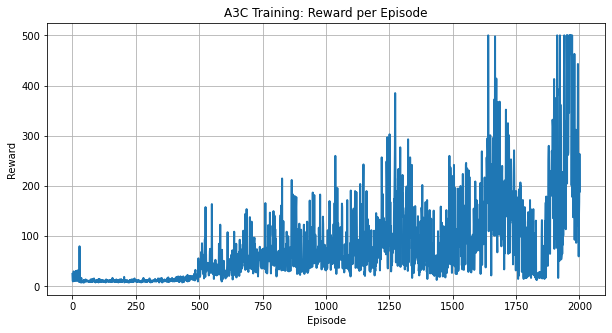

In [4]:
plot_training_rewards(training_rewards)

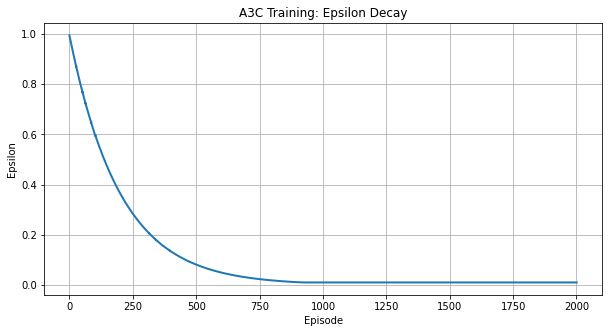

In [5]:
plot_epsilon_decay(epsilons)

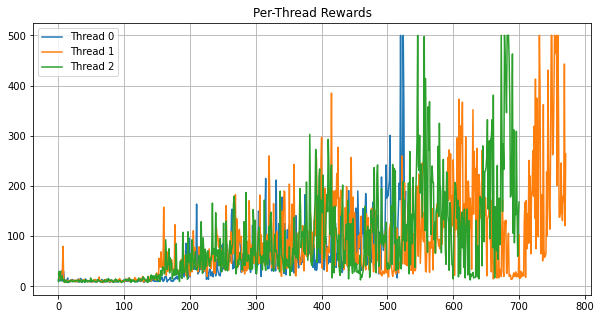

In [6]:
plot_threads(per_thread)

Eval returns: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Avg return: 500.0


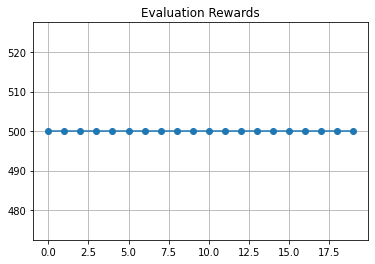

In [19]:
ENV_NAME = 'CartPole-v1'
rewards = evaluate(ENV_NAME, net, episodes=20, do_plot=True)

In [20]:
#Saves the trained model 
torch.save(net.state_dict(), 'a3c_cartpole.pth')

For loading the model and saving a render of an episode, we reinstantiate the model and run it for an episode to record the render/video.

In [27]:
#Defines the architecture (must match training) for evaluating
class ActorCritic(torch.nn.Module):
    def __init__(self, obs_dim, act_dim, h1=256, h2=128):
        super().__init__()
        self.hidden1 = torch.nn.Linear(obs_dim, h1)
        self.hidden2 = torch.nn.Linear(h1, h2)
        self.pi_head = torch.nn.Linear(h2, act_dim)
        self.v_head  = torch.nn.Linear(h2, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.pi_head(x), self.v_head(x)

sample_env = gym.make("CartPole-v1")
obs_dim = sample_env.observation_space.shape[0]
act_dim = sample_env.action_space.n
sample_env.close()

#Instantiates & loads the trained model
model = ActorCritic(obs_dim, act_dim)
state_dict = torch.load("a3c_cartpole.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

video_folder = "video_output2"
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env,
                  video_folder=video_folder,
                  episode_trigger=lambda ep: True,   # record every episode
                  name_prefix="cartpole")

obs, _    = env.reset()
done      = False
total_r   = 0.0

while not done:
    with torch.no_grad():
        logits, _ = model(torch.from_numpy(obs).float().unsqueeze(0))
        action = torch.argmax(F.softmax(logits, -1), dim=-1).item()

    obs, reward, terminated, truncated, _ = env.step(action)
    done   = terminated or truncated
    total_r += reward

print(f"Episode reward: {total_r:.2f}")
env.close()

Episode reward: 500.00
